# Baseline Model w/ only numerical data

## 1. Import Dependencies

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes

## 2. Import Dataset

In [2]:
df = pd.read_csv('../data/tese.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   account_id                                  50000 non-null  object 
 1   country_name                                50000 non-null  object 
 2   account_category                            50000 non-null  object 
 3   bi_account_classification                   50000 non-null  object 
 4   customer_type                               50000 non-null  object 
 5   company_name                                49995 non-null  object 
 6   domain                                      49945 non-null  object 
 7   city                                        49965 non-null  object 
 8   sic_code                                    22107 non-null  float64
 9   companydataprovider_companyname             34549 non-null  object 
 10  companydat

In [4]:
df.head()

,account_id,country_name,account_category,bi_account_classification,customer_type,company_name,domain,city,sic_code,companydataprovider_companyname,...,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,business_model,is_subscription,is_customer_perpetual
0,3609465D-A808-EB11-95AA-005056A7C91D,Brazil,Standard,Inside Sales,Customer,Guaçu S/A Papeis e Embalagens,@guacu.com.br,estiva gerbi,NaN,NaN,...,3,3,4,822.49,215.03,8086,215.03,S,True,False
1,3657E19B-FD1A-E411-80D3-005056846F2F,Germany,Standard,Inside Sales,Customer,Stadtwerke Bad Schwalbach,@bad-schwalbach.de,Bad Schwalbach,NaN,Stadtwerke Schwalbach/Taunus,...,9,2,4,2937.39,837.22,8080,837.22,S,True,False
2,8451D3C3-FC1A-E411-80D3-005056846F2F,Italy,Standard,Inside Sales,Customer,Prussiani Engineering s.r.l.,@prussiani.com,Albano Sant'Alessandro,3559.0,PRUSSIANI ENGINEERING SPA,...,13,2,6,5884.78,1157.72,12106,1157.72,S,True,False
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,Netherlands,Standard,Inside Sales,Customer,Kadoelenwerf Jachtservice & Haven,@hotmail.com,Amsterdam,4493.0,Jachthaven Kadoelenwerf c.v.,...,1,1,2,861.84,478.80,4045,478.80,S,True,False
4,3151AAFA-F21A-E411-80D3-005056846F2F,Switzerland,Standard,Inside Sales,Customer,Casinò Lugano SA,@casinolugano.ch,Lugano,7999.0,Casinò Lugano SA,...,12,5,7,3538.54,533.25,14134,533.25,S,True,False


## 3. Data Preprocessing

### 3.1. Add SIC Code & Description

In [5]:
df_sic_codes = pd.read_excel('../data/sic_4_digit_codes.xls')

In [6]:
df_sic_codes

,Code Value,Description
0,111,Wheat
1,112,Rice
2,115,Corn
3,116,Soybeans
4,119,"Cash grains, nec"
...,...,...
1000,9651,"Regulation, miscellaneous commercial sectors"
1001,9661,Space research and technology
1002,9711,National security
1003,9721,International affairs


In [7]:
# Merge df and df_sic_codes and add the 'description' column to df
df = df.merge(df_sic_codes, left_on='sic_code', right_on='Code Value', how='left')

In [8]:
# Rename the 'description' column to 'code_description'
df.rename(columns={'Description': 'sic_code_description'}, inplace=True)

### 3.2. Add Industry

In [9]:
# Define a dictionary to map SIC code ranges to major industry groups
major_groups = {
    range(1, 10): 'Agriculture, Forestry, and Fishing',
    range(10, 15): 'Mining',
    range(15, 18): 'Construction',
    range(20, 40): 'Manufacturing',
    range(40, 50): 'Transportation, Communications, Electric, Gas, and Sanitary Services',
    range(50, 53): 'Wholesale Trade',
    range(52, 60): 'Retail Trade',
    range(60, 68): 'Finance, Insurance, and Real Estate',
    range(70, 90): 'Services',
    range(90, 100): 'Public Administration'
}

# Map SIC code ranges to major industry group descriptions
def map_to_major_group(sic_code):
    for group_range, description in major_groups.items():
        if sic_code // 100 in group_range:
            return description
    return 'Unknown'

In [10]:
df['industry'] = df['sic_code'].apply(map_to_major_group)

In [11]:
df.head()

,account_id,country_name,account_category,bi_account_classification,customer_type,company_name,domain,city,sic_code,companydataprovider_companyname,...,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,business_model,is_subscription,is_customer_perpetual,Code Value,sic_code_description,industry
0,3609465D-A808-EB11-95AA-005056A7C91D,Brazil,Standard,Inside Sales,Customer,Guaçu S/A Papeis e Embalagens,@guacu.com.br,estiva gerbi,NaN,NaN,...,822.49,215.03,8086,215.03,S,True,False,NaN,NaN,Unknown
1,3657E19B-FD1A-E411-80D3-005056846F2F,Germany,Standard,Inside Sales,Customer,Stadtwerke Bad Schwalbach,@bad-schwalbach.de,Bad Schwalbach,NaN,Stadtwerke Schwalbach/Taunus,...,2937.39,837.22,8080,837.22,S,True,False,NaN,NaN,Unknown
2,8451D3C3-FC1A-E411-80D3-005056846F2F,Italy,Standard,Inside Sales,Customer,Prussiani Engineering s.r.l.,@prussiani.com,Albano Sant'Alessandro,3559.0,PRUSSIANI ENGINEERING SPA,...,5884.78,1157.72,12106,1157.72,S,True,False,3559.0,"Special industry machinery, nec",Manufacturing
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,Netherlands,Standard,Inside Sales,Customer,Kadoelenwerf Jachtservice & Haven,@hotmail.com,Amsterdam,4493.0,Jachthaven Kadoelenwerf c.v.,...,861.84,478.80,4045,478.80,S,True,False,4493.0,Marinas,"Transportation, Communications, Electric, Gas,..."
4,3151AAFA-F21A-E411-80D3-005056846F2F,Switzerland,Standard,Inside Sales,Customer,Casinò Lugano SA,@casinolugano.ch,Lugano,7999.0,Casinò Lugano SA,...,3538.54,533.25,14134,533.25,S,True,False,7999.0,"Amusement and recreation, nec",Services


### 3.3. Cleaning

We will be working with only *non-null* values.

In [12]:
df = df.dropna()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18150 entries, 2 to 49998
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   account_id                                  18150 non-null  object 
 1   country_name                                18150 non-null  object 
 2   account_category                            18150 non-null  object 
 3   bi_account_classification                   18150 non-null  object 
 4   customer_type                               18150 non-null  object 
 5   company_name                                18150 non-null  object 
 6   domain                                      18150 non-null  object 
 7   city                                        18150 non-null  object 
 8   sic_code                                    18150 non-null  float64
 9   companydataprovider_companyname             18150 non-null  object 
 10  companydat

In [17]:
# Separate categorical features
data = df.select_dtypes(include='object')

In [18]:
data

,account_id,country_name,account_category,bi_account_classification,customer_type,company_name,domain,city,companydataprovider_companyname,teamviewer_location,major_edition,initial_edition,current_edition,last_invoice_date_created,current_sales_channel,business_model,sic_code_description,industry
2,8451D3C3-FC1A-E411-80D3-005056846F2F,Italy,Standard,Inside Sales,Customer,Prussiani Engineering s.r.l.,@prussiani.com,Albano Sant'Alessandro,PRUSSIANI ENGINEERING SPA,EMEA,Corporate,Premium,Corporate,2023-08-31 02:06:03,Inside Sales,S,"Special industry machinery, nec",Manufacturing
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,Netherlands,Standard,Inside Sales,Customer,Kadoelenwerf Jachtservice & Haven,@hotmail.com,Amsterdam,Jachthaven Kadoelenwerf c.v.,EMEA,Business,Business,Business,2023-09-28 03:58:39,Inside Sales,S,Marinas,"Transportation, Communications, Electric, Gas,..."
4,3151AAFA-F21A-E411-80D3-005056846F2F,Switzerland,Standard,Inside Sales,Customer,Casinò Lugano SA,@casinolugano.ch,Lugano,Casinò Lugano SA,EMEA,Business,Business,Business,2023-06-28 03:00:04,Webshop,S,"Amusement and recreation, nec",Services
5,7CA97D7A-A1F0-EC11-BB3D-000D3AB57339,United States,Standard,Inside Sales,Customer,Delaney's Irish Pub,@delaneystx.com,McKinney,Delaney's Irish Pub,AMERICAS,Remote Access,Remote Access,Remote Access,2023-06-20 03:30:54,Webshop,S,Drinking places,Retail Trade
7,FFE48D4C-A666-EA11-A811-000D3AB11761,France,Standard,Inside Sales,Customer,smt,@wanadoo.fr,paris,SMT,EMEA,Remote Access,Remote Access,Remote Access,2023-03-15 02:46:59,Webshop,S,"Local trucking, without storage","Transportation, Communications, Electric, Gas,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49969,9DC5CDED-C898-ED11-AAD1-000D3ADEA83D,Austria,Standard,Inside Sales,Customer,Mineralstoffverwertungsgesellschaft mbH,@wienerberger.com,Wien,Mineralstoffverwertungsgesellschaft mbH,EMEA,Remote Access,Remote Access,Remote Access,2023-06-16 07:40:19,Webshop,S,Refuse systems,"Transportation, Communications, Electric, Gas,..."
49973,D0B6E4F9-E81A-E411-80D3-005056846F2F,United States,Standard,Inside Sales,Customer,"Authenticom, Inc.",@authenticom.com,La Crosse,Authenticom,AMERICAS,Corporate,Corporate,Corporate,2023-05-23 02:31:49,Inside Sales,S,Data processing and preparation,Services
49981,8CD2F113-BF75-EB11-A812-000D3AB25E8C,France,Standard,Inside Sales,Customer,Etablissement Gerace Peinture,@gmail.com,Grasse,ETABLISSEMENTS GERACE PEINTURE,EMEA,Business,Business,Business,2023-02-25 02:17:03,Inside Sales,S,Painting and paper hanging,Construction
49994,95C51C1D-A4D6-E711-80EF-005056844077,United States,Standard,Inside Sales,Customer,Velociti Inc.,@velociti.com,Riverside,velocity,AMERICAS,Corporate,Corporate,Corporate,2023-02-04 03:07:34,Inside Sales,S,"Services, nec",Services


### 3.4. Feature Selection

Write a little explanation about the selection method.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18150 entries, 2 to 49998
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   account_id                       18150 non-null  object
 1   country_name                     18150 non-null  object
 2   account_category                 18150 non-null  object
 3   bi_account_classification        18150 non-null  object
 4   customer_type                    18150 non-null  object
 5   company_name                     18150 non-null  object
 6   domain                           18150 non-null  object
 7   city                             18150 non-null  object
 8   companydataprovider_companyname  18150 non-null  object
 9   teamviewer_location              18150 non-null  object
 10  major_edition                    18150 non-null  object
 11  initial_edition                  18150 non-null  object
 12  current_edition                 

In [21]:
categorical_features = ['account_id', 'account_category', 'bi_account_classification',
       'customer_type', 'teamviewer_location', 'major_edition', 'current_sales_channel', 'business_model', 'industry']

data = data[categorical_features].copy()

data

,account_id,account_category,bi_account_classification,customer_type,teamviewer_location,major_edition,current_sales_channel,business_model,industry
2,8451D3C3-FC1A-E411-80D3-005056846F2F,Standard,Inside Sales,Customer,EMEA,Corporate,Inside Sales,S,Manufacturing
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,Standard,Inside Sales,Customer,EMEA,Business,Inside Sales,S,"Transportation, Communications, Electric, Gas,..."
4,3151AAFA-F21A-E411-80D3-005056846F2F,Standard,Inside Sales,Customer,EMEA,Business,Webshop,S,Services
5,7CA97D7A-A1F0-EC11-BB3D-000D3AB57339,Standard,Inside Sales,Customer,AMERICAS,Remote Access,Webshop,S,Retail Trade
7,FFE48D4C-A666-EA11-A811-000D3AB11761,Standard,Inside Sales,Customer,EMEA,Remote Access,Webshop,S,"Transportation, Communications, Electric, Gas,..."
...,...,...,...,...,...,...,...,...,...
49969,9DC5CDED-C898-ED11-AAD1-000D3ADEA83D,Standard,Inside Sales,Customer,EMEA,Remote Access,Webshop,S,"Transportation, Communications, Electric, Gas,..."
49973,D0B6E4F9-E81A-E411-80D3-005056846F2F,Standard,Inside Sales,Customer,AMERICAS,Corporate,Inside Sales,S,Services
49981,8CD2F113-BF75-EB11-A812-000D3AB25E8C,Standard,Inside Sales,Customer,EMEA,Business,Inside Sales,S,Construction
49994,95C51C1D-A4D6-E711-80EF-005056844077,Standard,Inside Sales,Customer,AMERICAS,Corporate,Inside Sales,S,Services


### 3.5. Feature Engineering

In [22]:
# Select the features (excluding the ID column)
features = data.iloc[:, 1:]

features

,account_category,bi_account_classification,customer_type,teamviewer_location,major_edition,current_sales_channel,business_model,industry
2,Standard,Inside Sales,Customer,EMEA,Corporate,Inside Sales,S,Manufacturing
3,Standard,Inside Sales,Customer,EMEA,Business,Inside Sales,S,"Transportation, Communications, Electric, Gas,..."
4,Standard,Inside Sales,Customer,EMEA,Business,Webshop,S,Services
5,Standard,Inside Sales,Customer,AMERICAS,Remote Access,Webshop,S,Retail Trade
7,Standard,Inside Sales,Customer,EMEA,Remote Access,Webshop,S,"Transportation, Communications, Electric, Gas,..."
...,...,...,...,...,...,...,...,...
49969,Standard,Inside Sales,Customer,EMEA,Remote Access,Webshop,S,"Transportation, Communications, Electric, Gas,..."
49973,Standard,Inside Sales,Customer,AMERICAS,Corporate,Inside Sales,S,Services
49981,Standard,Inside Sales,Customer,EMEA,Business,Inside Sales,S,Construction
49994,Standard,Inside Sales,Customer,AMERICAS,Corporate,Inside Sales,S,Services


In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18150 entries, 2 to 49998
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   account_category           18150 non-null  object
 1   bi_account_classification  18150 non-null  object
 2   customer_type              18150 non-null  object
 3   teamviewer_location        18150 non-null  object
 4   major_edition              18150 non-null  object
 5   current_sales_channel      18150 non-null  object
 6   business_model             18150 non-null  object
 7   industry                   18150 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


In [25]:
# Create an encoder
encoder = OneHotEncoder(sparse=False)  # Set sparse=False for easier handling

categorical_features = features.columns

# Fit the encoder on the features
encoded_data = encoder.fit_transform(data[categorical_features])

In [26]:
# statistics of scaled data
pd.DataFrame(encoded_data).describe()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
count,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,...,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000,18150.000000
mean,0.018402,0.002810,0.000551,0.978237,0.018402,0.940000,0.002810,0.004077,0.034711,0.957025,...,0.014435,0.059229,0.055096,0.168815,0.003140,0.016364,0.083361,0.448209,0.050579,0.100771
std,0.134404,0.052936,0.023467,0.145913,0.134404,0.237493,0.052936,0.063724,0.183051,0.202807,...,0.119280,0.236059,0.228175,0.374599,0.055954,0.126873,0.276435,0.497324,0.219141,0.301034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.6. Determine the number of clusters(k)

In [29]:
# Define a range of k values to test
k_range = range(1, 10)

# Create a list to store WCSS values
wcss = []

for k in k_range:
  # Create a KMeans object with the current k value
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
  # Fit the model on the scaled features
  kmeans.fit(encoded_data)
  # Get the WCSS value (inertia_)
  wcss.append(kmeans.inertia_)

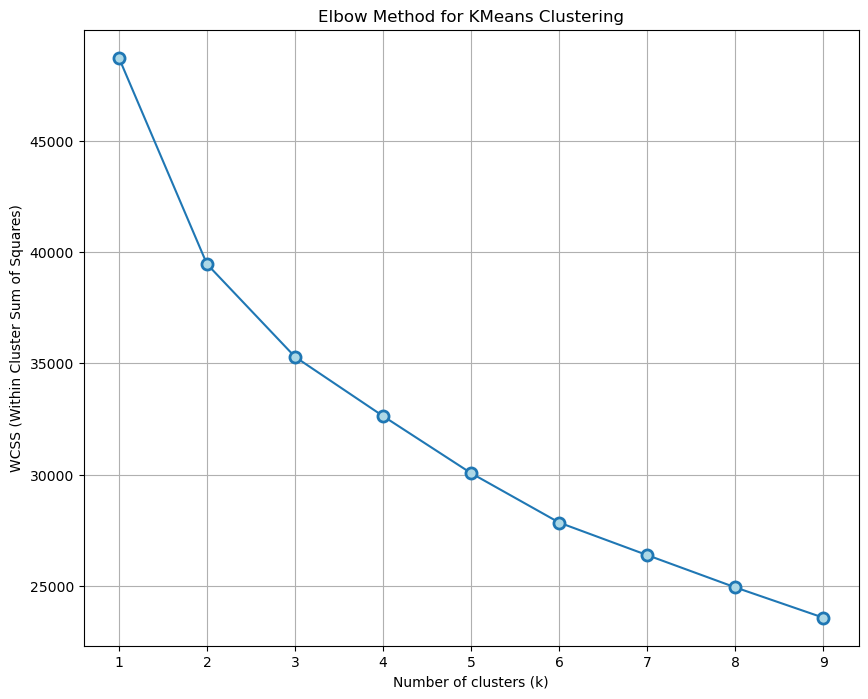

In [30]:
# Converting the results into a DataFrame
frame = pd.DataFrame({'Cluster':k_range, 'WCSS':wcss})

# Plot the WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()

## 4. Modeling

### 4.1. KModes

In [32]:
# Assuming your data is loaded into a pandas DataFrame called 'df'
kmodes_clusterer = KModes(n_clusters=5, init='Huang')
kmodes_clusterer.fit(features)

# Add the cluster labels to the original DataFrame
df['cluster'] = kmodes_clusterer.labels_

In [34]:
kmodes_model = KModes(n_clusters=5, init='Cao')

# 'Cao' initialization is a common strategy for categorical data
kmodes_result = kmodes_model.fit_predict(features)

# Add the cluster labels to the original DataFrame
df['cluster'] = kmodes_result

### 4.1. KMeans

In [58]:
# Assuming k based on the Elbow Method
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
kmeans.fit(encoded_data)
pred = kmeans.predict(encoded_data)

In [59]:
# Value count of points in each of the above-formed clusters
frame = pd.DataFrame(encoded_data)
frame['cluster'] = pred
frame['cluster'].value_counts()

1    6639
2    6028
7    4355
0     992
6      76
4      37
3      11
8      10
9       1
5       1
Name: cluster, dtype: int64

In [62]:
# Assign the columns of new_points (xs and ys) for plotting (assuming 2D data)
xs = features_scaled[:, 0]
ys = features_scaled[:, 1]

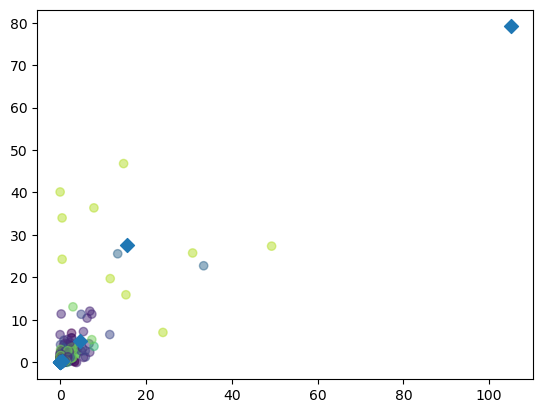

In [63]:
# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs, ys, c=pred, alpha=0.5)

# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x, centroids_y, marker='D',s=50)
plt.show()

### 4.2. DBSCAN

In [ ]:
# Create visualization of the clusters

## 5. Evaluation

### 5.1. KMeans

In [52]:
silhouette_score(features_scaled, cluster_labels)

0.41163754126815194

In [64]:
data['cluster'] = cluster_labels

data

,account_id,companydataprovider_employeenumber,companydataprovider_revenue_in_eur,number_distinct_active_licenses,total_connections_12m,total_endpoints_12m,total_devices_12m,days_from_last_invoice,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,cluster
2,8451D3C3-FC1A-E411-80D3-005056846F2F,52.0,15379307.0,3,3349,611,21,85,13,2,6,5884.78,1157.72,12106,1157.72,1
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,3.0,82742.0,1,78,4,2,57,1,1,2,861.84,478.80,4045,478.80,0
4,3151AAFA-F21A-E411-80D3-005056846F2F,242.0,15454197.0,1,243,33,3,149,12,5,7,3538.54,533.25,14134,533.25,1
5,7CA97D7A-A1F0-EC11-BB3D-000D3AB57339,7.0,830000.0,1,944,5,7,157,1,1,2,311.79,152.72,4045,152.72,0
7,FFE48D4C-A666-EA11-A811-000D3AB11761,21.0,985411.0,1,0,0,0,254,3,3,4,475.20,118.80,8086,118.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49969,9DC5CDED-C898-ED11-AAD1-000D3ADEA83D,9.0,3111000.0,1,297,7,16,161,0,0,2,266.42,266.42,4046,266.42,0
49973,D0B6E4F9-E81A-E411-80D3-005056846F2F,105.0,18900000.0,3,3512,1578,168,185,13,7,12,34539.78,4914.17,24205,4914.15,1
49981,8CD2F113-BF75-EB11-A812-000D3AB25E8C,7.0,930779.0,1,561,9,2,272,2,2,3,1109.12,391.52,6066,391.52,0
49994,95C51C1D-A4D6-E711-80EF-005056844077,5.0,954000.0,2,775,89,22,293,10,4,15,28771.99,4683.27,24215,4683.26,1
